# Imports

In [1]:
import os

import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


from copy import deepcopy

import spacy


# Set random seed for reproducibility
SEED=42
np.random.seed(SEED)

from utilities.funcoes import get_covid_legal_frameworks, preprocess_text
from utilities.schema import contracts_schema, procedimentos_schema


from pathlib import Path
from collections import Counter


c:\Users\carol\Documents\bolsa\Text_Fields\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [2]:
# already preprocessed

contratos = pl.read_parquet(
    "../../data/contratos_cleaned_prepro.parquet",
    columns=[
        "N.º Procedimento (ID BASE)", "N.º Contrato", "Tipo(s) de contrato_LIMPO", "Objeto_LIMPO", "Objeto_LIMPO_2", "Objeto", "Tipo de procedimento"
    ]
    )


procedimentos = pl.read_csv("../../data/impic_data/procedimentos.csv",
                            separator=";",
                            schema_overrides=procedimentos_schema(),
                            columns=[
                                "ContractingProcedureAliasID", "Regime de Contratação"
                                     ],
                            null_values=["NULL"]) \
                            .unique(subset="ContractingProcedureAliasID")


contratos_raw = pl.read_csv("../../data/impic_data/contratos.csv", separator=";", schema_overrides=contracts_schema(),
    columns=['N.º Procedimento (ID BASE)', 'N.º Contrato', 'Data da decisão adjudicação', 
             'Data Celebração', "Contratação Excluída", "Tipo de procedimento", "Medidas Especiais",
              "Ao abrigo dos critérios materiais", 'Preço BASE (€)', 'Preço Contratual (€)'], 
    null_values=["NULL"]) \
    .with_columns(
        pl.col("Data da decisão adjudicação").replace("NULL", None).str.split(" ").list.first().str.replace("'", "").str.to_date("%F"),
        pl.col('Data Celebração').replace("NULL", None).str.split(" ").list.first().str.replace("'", "").str.to_date("%F"),
    ) \
    .with_columns(
        pl.col("Data Celebração").dt.year().alias("contract_year")
    ) \
    .join(procedimentos, how="left", left_on="N.º Procedimento (ID BASE)", right_on="ContractingProcedureAliasID", coalesce=True) \
    .filter(pl.col("Contratação Excluída") == False) \
    .filter(pl.col("Tipo de procedimento").is_in(["Concurso público", "Concurso limitado por prévia qualificação"])) \
    .filter(pl.col("Medidas Especiais").is_null()) \
    .filter(~pl.col("Regime de Contratação").str.contains_any(get_covid_legal_frameworks())) \
    .unique(subset=['N.º Procedimento (ID BASE)', 'N.º Contrato']).select(['N.º Procedimento (ID BASE)', 'N.º Contrato', "contract_year"])

In [3]:
contratos = contratos.join(contratos_raw, how="inner", on=['N.º Procedimento (ID BASE)', 'N.º Contrato'], coalesce=True)

# Object Analysis

In [9]:
# preprocessar o objeto para medir o tamanho e para passar no pos tagging
# ver a distribuição do tamanho do objeto por ano, por tipo de procedimento, 
# por entidade adjudicatária, por local de Local de execução das principais prestações objeto do contrato
contratos = contratos.with_columns(
    pl.col("Objeto_LIMPO").map_elements(preprocess_text, return_dtype=pl.Utf8).alias("Objeto_LIMPO_Final")
)

In [10]:
objeto_prepro = contratos.select(["Objeto_LIMPO_Final", "Objeto","N.º Procedimento (ID BASE)", "N.º Contrato", "Tipo de procedimento"]).to_pandas()
objeto_prepro["Objeto_len"] = objeto_prepro["Objeto_LIMPO_Final"].str.split().str.len()

In [11]:
objeto_prepro[objeto_prepro["Objeto_len"]>400]['Objeto'].values[:10]

array([], dtype=object)

In [12]:
objeto_prepro[objeto_prepro["Objeto_len"]!=0]["Objeto_len"].describe().round(1)

count    69237.0
mean        15.4
std         11.6
min          1.0
25%          8.0
50%         13.0
75%         19.0
max        318.0
Name: Objeto_len, dtype: float64

In [13]:
objeto_prepro[(objeto_prepro["Objeto_len"]>300) & (objeto_prepro["Objeto_len"]<400)]["Objeto"].values[:50]

array(['Execução, de acordo com o caderno de encargos, da empreitada de remodelação e ampliação dos Sistemas de Abastecimento e de Drenagem do Porto Santo ? Fase 1 ? 2.º Procedimento, que assenta resumidamente nos seguintes trabalhos: \na) Atualização e integração das zonas de medição e controlo (ZMC) no sistema de telegestão da A.R.M., S.A.: \ni. Trabalhos de construção civil associados a intervenções de reabilitação das infraestruturas; \nii. Instalação/ substituição de tubagens e acessórios associados a intervenções de reabilitação; \niii. Instalação de equipamentos tais como caudalímetros eletromagnéticos nas condutas de saída para a rede, e em condutas de adução aos reservatórios, sondas de nível ultrassónicas nas células dos reservatórios, bóias de nível nas células, instalação de sistemas de detetores de intrusão e inundação; \niv. Execução de ramal elétrico, caso necessário; \nv. Instalação de equipamentos e instrumentação associados aos sistemas de controlo, comunicação e auto

<Axes: >

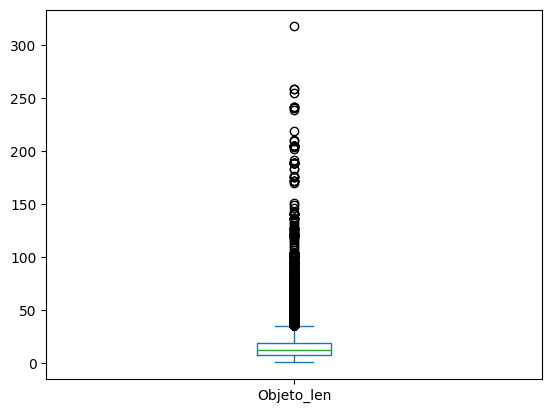

In [14]:
objeto_prepro["Objeto_len"].plot(kind="box")

<Axes: >

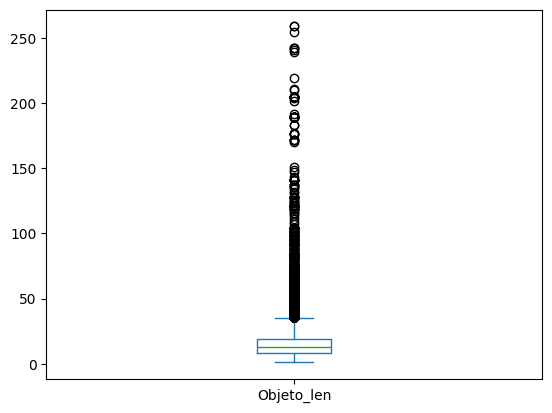

In [15]:
objeto_prepro[objeto_prepro["Objeto_len"]<300]["Objeto_len"].plot(kind="box")


In [16]:
contratos = contratos.with_columns(
    pl.Series("objeto_len", objeto_prepro["Objeto_len"].to_numpy())
)

Entidade adjudicatária não tem nenhuma diferena no que toca ao tamanho do objeto contratual.

Parece que objetos contratuais que são muito longos foram mal inseridos. Têm muitas tags de html e parecem muitas vezes dados de tabelas que foram passados para texto.

Verificar se os contratos onde isto acontece são contratos por lotes.

# POS TAGGING

In [ ]:
# other things to try here:

## other from spacy

# nlp = spacy.load("pt_core_news_trf")

## stanza library

# import stanza
# stanza.download("pt")

# nlp = stanza.Pipeline("pt")
# doc = nlp("Este é um exemplo.")

In [ ]:
nlp = spacy.load("pt_core_news_sm")


nlp.disable_pipes("parser", "ner")

['parser', 'ner']

In [16]:
# objeto_prepro_sample = objeto_prepro[:100]

# 2) Textos
textos = objeto_prepro["Objeto_LIMPO_Final"].fillna("").astype(str).tolist()

# 3) Função de contagem
def count_words_and_pos(doc):
    tokens = [
        t for t in doc
        if not t.is_space and not t.is_punct
    ]
    
    total_words = len(tokens)
    pos_counts = Counter(t.pos_ for t in tokens)
    
    return total_words, pos_counts

# 4) Processamento em batch
docs = list(nlp.pipe(textos, batch_size=256))



In [17]:
# 5) Aplicar
results = [count_words_and_pos(doc) for doc in docs]

# 6) Separar resultados
objeto_prepro["n_palavras_total"] = [r[0] for r in results]

pos_df = pd.DataFrame([r[1] for r in results]).fillna(0).astype(int)

# 7) Juntar tudo
objeto_prepro = pd.concat(
    [objeto_prepro.reset_index(drop=True), pos_df],
    axis=1
)

In [18]:
objeto_prepro["n_palavras_total"].describe()

count    937860.000000
mean         13.461291
std          12.986482
min           0.000000
25%           7.000000
50%          11.000000
75%          17.000000
max        1816.000000
Name: n_palavras_total, dtype: float64

In [19]:
objeto_prepro.columns

Index(['Objeto_LIMPO_Final', 'Objeto', 'N.º Procedimento (ID BASE)',
       'N.º Contrato', 'Tipo de procedimento', 'Objeto_len',
       'n_palavras_total', 'NOUN', 'ADP', 'DET', 'ADJ', 'NUM', 'SCONJ', 'VERB',
       'CCONJ', 'PROPN', 'ADV', 'PRON', 'AUX', 'X', 'SYM', 'PUNCT', 'PART',
       'INTJ'],
      dtype='object')

In [20]:
objeto_prepro[["Objeto_LIMPO_Final", "Objeto", "N.º Procedimento (ID BASE)", "N.º Contrato", 'Objeto_len', 'n_palavras_total', 'NOUN', 'ADP',
       'NUM', 'ADJ', 'PROPN', 'X', 'CCONJ', 'ADV', 'DET', 'VERB', 'SYM',
       'PRON', 'AUX', 'SCONJ', 'PUNCT', 'INTJ', 'PART']].to_csv("../../data/resultados_pos_tagging.csv")

In [21]:
objeto_prepro = objeto_prepro[objeto_prepro['n_palavras_total']!=0]

In [22]:
objeto_prepro['n_palavras_total'].describe()

count    937855.000000
mean         13.461362
std          12.986479
min           1.000000
25%           7.000000
50%          11.000000
75%          17.000000
max        1816.000000
Name: n_palavras_total, dtype: float64

In [23]:
objeto_prepro['NOUN'].describe()

count    937855.000000
mean          5.041995
std           4.585971
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         490.000000
Name: NOUN, dtype: float64

In [24]:
objeto_prepro['NUM'].describe()

count    937855.000000
mean          1.208267
std           2.279907
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         496.000000
Name: NUM, dtype: float64

In [25]:
objeto_prepro['ADJ'].describe()

count    937855.000000
mean          1.346157
std           1.739832
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         200.000000
Name: ADJ, dtype: float64

In [26]:
objeto_prepro['VERB'].describe()

count    937855.000000
mean          0.551140
std           1.151766
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         188.000000
Name: VERB, dtype: float64